In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import numpy as np

import math

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [4]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [5]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [6]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [7]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

In [8]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 100

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Using 8Khz. We start with 4 layer 1D convolutional layers for feature extraction that go from 1 to 256 channels with batch normalization and 1D maxpooling, we add another two layers (5th and 6th) with maxpooling and then connect 2048 channels to a LSTM with 256 hidden dimension units that end up to a fully connected linear layer.

In [9]:
class ModelNetwork(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=256, n_channel=128, nhead=2, dropout=0.1, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(2 * n_channel, 8 * n_channel, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(8 * n_channel)
        self.pool5 = nn.MaxPool1d(4)
        self.conv6 = nn.Conv1d(8 * n_channel, 16 * n_channel, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(16 * n_channel)
        self.pool6 = nn.MaxPool1d(4)
        self.LSTM = nn.LSTM(16 * n_channel, 8 * hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(8 * hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        x = self.conv6(x)
        x = F.relu(self.bn6(x))

        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.LSTM(x)
        x = self.fc1(hn[-1])
        return F.log_softmax(x, dim=-1)

model = ModelNetwork(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
#print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 36367651


In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [11]:
def train(epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())


In [12]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


@torch.no_grad()
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    correct = 0
    n = 0
    for data, target in data_source:

        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        total_loss += target.numel() * F.nll_loss(output.squeeze(), target).item()
        n += target.numel()

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
    
 
    accuracy = 100 * correct / len(test_loader.dataset)
    
    return total_loss / n, accuracy

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.559215
Train Epoch: 1 [10000/84843 (12%)]	Loss: 2.378242
Train Epoch: 1 [20000/84843 (24%)]	Loss: 1.612399
Train Epoch: 1 [30000/84843 (35%)]	Loss: 1.263310
Train Epoch: 1 [40000/84843 (47%)]	Loss: 1.288627
Train Epoch: 1 [50000/84843 (59%)]	Loss: 1.136693
Train Epoch: 1 [60000/84843 (71%)]	Loss: 0.867004
Train Epoch: 1 [70000/84843 (82%)]	Loss: 0.614255
Train Epoch: 1 [80000/84843 (94%)]	Loss: 0.966478
| Validation | val loss  0.85 | val accuracy 67%
Train Epoch: 2 [0/84843 (0%)]	Loss: 0.541868
Train Epoch: 2 [10000/84843 (12%)]	Loss: 0.697994
Train Epoch: 2 [20000/84843 (24%)]	Loss: 0.675283
Train Epoch: 2 [30000/84843 (35%)]	Loss: 0.817665
Train Epoch: 2 [40000/84843 (47%)]	Loss: 0.576284
Train Epoch: 2 [50000/84843 (59%)]	Loss: 0.410466
Train Epoch: 2 [60000/84843 (71%)]	Loss: 0.445038
Train Epoch: 2 [70000/84843 (82%)]	Loss: 0.506037
Train Epoch: 2 [80000/84843 (94%)]	Loss: 0.500331
| Validation | val loss  0.65 | val accuracy 73%
Train Epoch:

Text(0.5, 1.0, 'training loss')

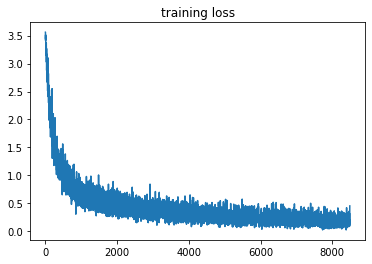

In [13]:
best_val_loss = float("inf")
losses = []

log_interval = 100
n_epoch = 10

transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train(epoch, log_interval)
    val_loss, val_acc = evaluate(val_loader)

    print(f'| Validation | val loss {val_loss:5.2f} | val accuracy {val_acc:.0f}%')

    if val_loss < best_val_loss:
      with open("best_checkpoint_LSTM_8kHz.pth", 'wb') as f:
        torch.save(model, f)
      best_val_loss = val_loss
    scheduler.step()

with open("best_checkpoint_LSTM_8kHz.pth", 'rb') as f:
  model = torch.load(f)

with torch.no_grad():
  test_loss, test_acc = evaluate(test_loader)

print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')
print('=' * 89)

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")